# Bulding the Rydberg 

This notebook contains the code and data to generate the results for the first part of the paper. This includes only classical stuff.

Structure of the notebook:
- [Build the material structure](#build_material)
- [Build the test/test set](#test_test)
- [Write CRYSTAL input files](#write_input)
- [Read CRYSTAL output files](#read_output)
- [Mapping to the Rydberg Hamiltonian](#mapping_to_ryd)
- [Approximations](#approximations)
- [Compare to QUBO model](#QUBO)
- [Classical Monte Carlo](#monte_carlo)

In [97]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from scipy.optimize import minimize
from scipy import constants

k_b = constants.physical_constants['Boltzmann constant in eV/K'][0]

from pymatgen.core.structure import Structure, Molecule
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer, PointGroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor

from ase.visualize import view

from utils import cut_graphene_rectangle
from random_structures import *
from QUBO_models import *

def vview(structure):
    view(AseAtomsAdaptor().get_atoms(structure))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Build the Material Structure
<a id="build_material"></a>

This section will focus on building the material structure, including relevant parameters and visualizations.

In [5]:
# Add the pymatgen structure here

In [182]:
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

supercell_order = 2
scaling_matrix = np.array([[supercell_order, 0, 0],
                            [0, supercell_order, 0],
                            [0, 0, 1]])
graphene_scell = copy.deepcopy(graphene)
graphene_scell.make_supercell(scaling_matrix)
# Reorder the atoms in the supercell so they follow the convention we are using (top to bottom, left to right).
ordering = [1,5,0,3,4,7,2,6]
graphene_scell = Structure(graphene_scell.lattice,graphene_scell.atomic_numbers,
                           graphene_scell.frac_coords[ordering])

graphene_mol_r_6_6 = cut_graphene_rectangle(graphene,15,14,center=True)
graphene_mol_r_6_6.remove_sites([1,5,11,18,25,32])
vview(graphene_mol_r_6_6)

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Add periodic boundary conditions

In [184]:
cell = np.array([[16.04, -2.134, 0.0],
                [ 0.0, 12.8 ,0.0],
                [0.0, 0.0, 10.0]])
graphene_mol_r_6_6_pbc = Structure(cell, graphene_mol_r_6_6.atomic_numbers, 
                                   graphene_mol_r_6_6.cart_coords, coords_are_cartesian=True)

vview(graphene_mol_r_6_6_pbc)

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


## Build the Test/test Set
<a id="test_test"></a>

In this section, we'll create the test and train datasets using the prepared material structure.

In [4]:
atom_indices = get_all_configurations(graphene_mol_r_6_6_pbc)

binary_an = []

for n,i in enumerate(np.arange(1,11,1)):
    
    active_sites = np.where(np.array(graphene_mol_r_6_6_pbc.atomic_numbers)==6)[0]
    N_atoms = i
    
    structures_random = generate_random_structures(graphene_mol_r_6_6_pbc,atom_indices=atom_indices,
                                                       N_atoms=N_atoms,
                                                       new_species=7,N_config=100,DFT_config=10,
                                                       return_multiplicity=False,
                                                       active_sites=active_sites)
    # print(i,len(structures_random))

    num_structures = len(structures_random)
    
    for structure in structures_random:
        binary_an_tmp = np.zeros(len(active_sites),dtype='int')
        binary_an_tmp[np.where(np.array(structure.atomic_numbers) == 7)[0]] = 1
        binary_an.append(binary_an_tmp)

binary_an = np.array(binary_an)

# np.savetxt('data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc_index_test.csv',binary_an,delimiter=',',fmt='%d')

## Write CRYSTAL Input Files
<a id="write_input"></a>

Here, we will generate the input files for the CRYSTAL simulation using the defined structure and parameters.

### Train set

In [ ]:
import copy
import shutil as sh
import numpy as np

# TRAIN
# Load the input template and indices
with open('data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc.d12') as file:
    input_template_save = file.readlines()

N_indices = np.genfromtxt(
    'data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc_index_train.csv',
    delimiter=','
).astype(int)

# Iterate over the training indices
for i, N_index in enumerate(N_indices):
    # Get positions and count of N atoms
    N_cry_position = np.where(N_index == 1)[0] + 1
    N_N = np.sum(N_index == 1)

    # Prepare the input template
    input_template = copy.deepcopy(input_template_save)
    input_template.insert(3, f'{len(N_cry_position)}\n')

    for j, N in enumerate(N_cry_position):
        input_template.insert(4 + j, f'{N} 7\n')

    # Define output file paths
    d12_filename = f'data/crystal/graphene/pbc/train_set/graphene_mol_r_6_6_h_{N_N}_{i % 10}.d12'
    gui_filename = f'data/crystal/graphene/pbc/train_set/graphene_mol_r_6_6_h_{N_N}_{i % 10}.gui'

    # Write the modified template to the output file
    with open(d12_filename, 'w') as file:
        file.writelines(input_template)

    # Copy the GUI file to the output directory
    sh.copy(
        './data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc.gui',
        gui_filename
    )

    # Print the command for running the script
#  print(f'/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_{N_N}_{i % 10} &')

### Test set

In [ ]:
import copy
import shutil as sh
import numpy as np

# Test
# Load the input template and indices
with open('data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc.d12') as file:
    input_template_save = file.readlines()

N_indices = np.genfromtxt(
    'data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc_index_test.csv',
    delimiter=','
).astype(int)

# Iterate over the testing indices
for i, N_index in enumerate(N_indices):
    # Get positions and count of N atoms
    N_cry_position = np.where(N_index == 1)[0] + 1
    N_N = np.sum(N_index == 1)

    # Prepare the input template
    input_template = copy.deepcopy(input_template_save)
    input_template.insert(3, f'{len(N_cry_position)}\n')

    for j, N in enumerate(N_cry_position):
        input_template.insert(4 + j, f'{N} 7\n')

    # Define output file paths
    d12_filename = f'data/crystal/graphene/pbc/test_set/graphene_mol_r_6_6_h_{N_N}_{i % 10}.d12'
    gui_filename = f'data/crystal/graphene/pbc/test_set/graphene_mol_r_6_6_h_{N_N}_{i % 10}.gui'

    # Write the modified template to the output file
    with open(d12_filename, 'w') as file:
        file.writelines(input_template)

    # Run the following only to generate the input files, then use the
    # ones generated by the calculation
    
    # # Copy the GUI file to the output directory
    # sh.copy(
    #     './data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc.gui',
    #     gui_filename
    # )

    # Print the command for running the script
#  print(f'/work/e05/e05/bcamino/runCRYSTAL/Pcry_slurm_multi graphene_mol_r_6_6_h_{N_N}_{i % 10} &')

## Read CRYSTAL Output Files
<a id="read_output"></a>

This section covers how to parse and interpret the output files produced by the CRYSTAL simulation.

In [146]:
import os
import numpy as np

N_atom = 7
N_sites = 78

train_folder = 'data/crystal/graphene/pbc/train_set/'
test_folder = 'data/crystal/graphene/pbc/test_set/'

def extract_final_energy(file_path):
    """
    Extract the final energy from a CRYSTAL output file.

    Parameters:
        file_path (str): Path to the .out file.

    Returns:
        float: Final energy in atomic units (AU) or None if not found.
    """
    with open(file_path, 'r') as f:
        for line in f:
            if '* OPT END - CONVERGED' in line:
                # Extract the energy from the line
                parts = line.split()
                return float(parts[7])  # Energy is the 7th element in the line
    return None

from pymatgen.core.structure import Structure
from pymatgen.core.lattice import Lattice

def read_gui_file(file_path):
    """
    Reads a .gui file and creates a pymatgen Structure object.
    
    Parameters:
        file_path (str): Path to the .gui file.
    
    Returns:
        pymatgen.core.structure.Structure: Pymatgen Structure object.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Parse lattice matrix (lines 2-4)
    lattice = []
    for i in range(1, 4):
        lattice.append([float(x) for x in lines[i].split()])

    # Skip symmetry operators
    num_symmetry_operators = int(lines[4].strip())
    start_index = 5 + 4 * num_symmetry_operators

    # Parse number of atoms
    num_atoms = int(lines[start_index].strip())
    start_index += 1

    # Parse atomic positions and numbers
    atomic_numbers = []
    cartesian_coords = []
    for i in range(start_index, start_index + num_atoms):
        parts = lines[i].split()
        atomic_numbers.append(int(parts[0]))  # Atomic number
        cartesian_coords.append([float(x) for x in parts[1:4]])  # Cartesian coordinates

    # Create and return the pymatgen Structure object
    lattice_matrix = Lattice(lattice)
    structure = Structure(
        lattice_matrix,
        atomic_numbers,
        cartesian_coords,
        coords_are_cartesian=True
    )
    return structure

def process_files(folder, structures, energies):
    """
    Process CRYSTAL .out files in a folder to extract structures and normalized energies.

    Parameters:
        folder (str): Path to the folder containing .out files.
        structures (list): List to store extracted structures.
        energies (list): List to store extracted normalized energies.
    """
    for file in os.listdir(folder):
        if file.endswith('.out'):
            file_name = file[:-4]
            file_path = os.path.join(folder, file)

            # Extract the final energy
            energy = extract_final_energy(file_path)
            if energy is None:
                continue  # Skip files without valid energy
            
            # Read the GUI file for the structure
            gui_file_path = os.path.join(folder, file_name + '.gui')
            structure = read_gui_file(gui_file_path)

            # Append structure to the list
            structures.append(structure)

            # Calculate normalized energy
            N_N = np.sum(np.array(structure.atomic_numbers) == 7)
            N_C = N_sites - N_N
            energy_norm = (energy - (E_C * N_C) - (E_N * N_N)) / N_sites
            energies.append(energy_norm)
            # energies.append(energy)

E_N = extract_final_energy('../QA_solid_solutions/data/crystal/graphene/N2.out')/2
E_C = extract_final_energy('data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc.out')/78
E_graphene = extract_final_energy(
    'data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc.out')


# Process training set
structures_train = []
energies_train = []
process_files(train_folder, structures_train, energies_train)

# Process test set
structures_test = []
energies_test = []
process_files(test_folder, structures_test, energies_test)

## Mapping to the Rydberg Hamiltonian
<a id="mapping_to_ryd"></a>

We'll map the results from CRYSTAL simulations to the Rydberg Hamiltonian in this section.

In [242]:
from sklearn.linear_model import LinearRegression
import numpy as np

def build_H_ryd(structure, binary_occ, energies, neighbor_counts, scaling_factors):
    """
    Build a QUBO matrix using machine learning based on a structure and training data.

    Parameters:
        structure (pymatgen.core.structure.Structure): Reference structure.
        binary_occ (list of np.ndarray): List of training configurations.
        energies (np.ndarray): Training target energies.
        neighbor_counts (list of int): Number of neighbors to include in each shell.
        scaling_factors (list of float): Scaling factors for each shell.

    Returns:
        np.ndarray: QUBO matrix.
    """
    # Step 1: Filter the distance matrix to include only specified neighbor shells
    distance_matrix = np.round(structure.distance_matrix, 5)
    num_sites = structure.num_sites

    # Sort the distance matrix and get sorted indices
    sorted_indices = np.argsort(distance_matrix, axis=1)
    sorted_distances = np.sort(distance_matrix, axis=1)

    # Initialize filtered distance matrix
    distance_matrix_filter = np.zeros_like(distance_matrix, dtype=float)

    # Assign scaling factors based on the number of neighbors per shell
    for i, (site_distances, site_indices) in enumerate(zip(sorted_distances, sorted_indices)):
        start_idx = 0
        for shell_idx, num_neighbors in enumerate(neighbor_counts):
            # Determine the indices for this shell
            end_idx = start_idx + num_neighbors
            neighbors = site_indices[start_idx:end_idx]  # Select neighbors
            distance_matrix_filter[i, neighbors] = scaling_factors[shell_idx]
            start_idx = end_idx

    # Upper triangular filtering and diagonal filling
    distance_matrix_filter = np.triu(distance_matrix_filter, k=0)
    np.fill_diagonal(distance_matrix_filter, 1)
 
    # Step 2: Build the descriptor for the training set
    upper_tri_indices = np.where(distance_matrix_filter != 0)
    descriptor = []

    for config in binary_occ:
        # Compute the outer product of the configuration vector
        matrix = np.outer(config, config)

        # Mask to select off-diagonal elements where matrix == 1
        mask = (matrix == 1) & (np.triu(np.ones_like(matrix), k=1) == 1)
        
        # Apply the mask to the distance_matrix_filter
        selected_elements = distance_matrix_filter[mask]

        # Descriptor includes the number of occupied sites and sum of selected elements
        num_occupied_sites = np.sum(config)
        descriptor.append([num_occupied_sites, np.sum(selected_elements)])

    descriptor = np.array(descriptor)

    # Step 3: Train a linear regression model
    reg = LinearRegression()
    reg.fit(descriptor, energies)

    # Print R^2 score
    print(f"R²: {reg.score(descriptor, energies):.4f}")


    return reg.coef_

In [329]:
import numpy as np

def calculate_Ryd_energy_pbc(structure, X_test, reg_coef, neighbor_count, scaling_factors):
    """
    Calculate the energy for test configurations using the regression coefficients and neighbor contributions.

    Parameters:
        structure (pymatgen.core.structure.Structure): Reference structure.
        X_test (list of np.ndarray): Test configurations.
        reg_coef (np.ndarray): Regression coefficients from the linear model.
        neighbor_counts (list of int): Number of neighbors to include in each shell.
        scaling_factors (list of float): Scaling factors for each shell.

    Returns:
        np.ndarray: Calculated energies for the test configurations.
    """
    # Step 1: Filter the distance matrix to include only specified neighbor shells
    distance_matrix = np.round(structure.distance_matrix, 5)
    num_sites = structure.num_sites

    # Sort the distance matrix and get sorted indices
    sorted_indices = np.argsort(distance_matrix, axis=1)
    sorted_distances = np.sort(distance_matrix, axis=1)

    # Initialize filtered distance matrix
    distance_matrix_filter = np.zeros_like(distance_matrix, dtype=float)

    # Assign scaling factors based on the number of neighbors per shell
    for i, (site_distances, site_indices) in enumerate(zip(sorted_distances, sorted_indices)):
        start_idx = 0
        for shell_idx, num_neighbors in enumerate(neighbor_count):
            # Determine the indices for this shell
            end_idx = start_idx + num_neighbors
            neighbors = site_indices[start_idx:end_idx]  # Select neighbors
            distance_matrix_filter[i, neighbors] = scaling_factors[shell_idx]
            start_idx = end_idx

    # Upper triangular filtering and diagonal filling
    distance_matrix_filter = np.triu(distance_matrix_filter, k=0)
    np.fill_diagonal(distance_matrix_filter, 1)

    # Step 2: Calculate the energy contributions for each test configuration
    energies = []
    for config in X_test:
        # Compute the outer product of the configuration vector
        matrix = np.outer(config, config)

        # Mask to select off-diagonal elements where matrix == 1
        mask = (matrix == 1) & (np.triu(np.ones_like(matrix), k=1) == 1)

        # Apply the mask to the distance_matrix_filter
        selected_elements = distance_matrix_filter[mask]

        # Calculate the energy contribution
        num_occupied_sites = np.sum(config)  # Contribution from the number of occupied sites
        pairwise_contribution = np.sum(selected_elements * reg_coef[1])  # Contribution from neighbors

        # Add all contributions
        energy = reg_coef[0] * num_occupied_sites + pairwise_contribution
        energies.append(energy)

    return np.array(energies)

In [321]:
import numpy as np

def calculate_Ryd_energy_mol(structure, X_test, reg_coef, scaling_factors):
    """
    Calculate the energy for test configurations using the regression coefficients and neighbor contributions.
    For the non periodic structure
    Parameters:
        structure (pymatgen.core.structure.Structure): Reference structure.
        X_test (list of np.ndarray): Test configurations.
        neighbor_counts (list of int): Number of neighbors to include in each shell.
        scaling_factors (list of float): Scaling factors for each shell.

    Returns:
        np.ndarray: Calculated energies for the test configurations.
    """
    # Step 1: Filter the distance matrix to include only specified neighbor shells
    structure = Molecule(structure.atomic_numbers,structure.cart_coords)
    distance_matrix = np.round(structure.distance_matrix, 5)
    num_sites = structure.num_sites

    num_sites = structure.num_sites
    distance_matrix_mol = np.round(structure.distance_matrix, 5)

    # Initialize an empty distance matrix
    distance_matrix_filter = np.zeros((num_sites, num_sites), dtype=float)

    # Get unique distance shells and limit to the maximum number of neighbors
    shells = np.unique(distance_matrix_mol)
    max_neigh = len(scaling_factors)

    # Assign scaled values to the distance matrix based on shells
    for i, shell in enumerate(shells[:max_neigh]):
        # Find row and column indices where the distance matches the current shell
        row_indices, col_indices = np.where(distance_matrix_mol == shell)
        # Apply the scaling factor to the corresponding entries
        distance_matrix_filter[row_indices, col_indices] = scaling_factors[i]

    # # Sort the distance matrix and get sorted indices
    # sorted_indices = np.argsort(distance_matrix, axis=1)
    # sorted_distances = np.sort(distance_matrix, axis=1)

    # # Initialize filtered distance matrix
    # distance_matrix_filter = np.zeros_like(distance_matrix, dtype=float)

    # # Assign scaling factors based on the number of neighbors per shell
    # for i, (site_distances, site_indices) in enumerate(zip(sorted_distances, sorted_indices)):
    #     start_idx = 0
    #     for shell_idx, num_neighbors in enumerate(neighbor_count):
    #         # Determine the indices for this shell
    #         end_idx = start_idx + num_neighbors
    #         neighbors = site_indices[start_idx:end_idx]  # Select neighbors
    #         distance_matrix_filter[i, neighbors] = scaling_factors[shell_idx]
    #         start_idx = end_idx

    # Upper triangular filtering and diagonal filling
    distance_matrix_filter = np.triu(distance_matrix_filter, k=0)
    np.fill_diagonal(distance_matrix_filter, 1)

    # Step 2: Calculate the energy contributions for each test configuration
    energies = []
    for config in X_test:
        # Compute the outer product of the configuration vector
        matrix = np.outer(config, config)

        # Mask to select off-diagonal elements where matrix == 1
        mask = (matrix == 1) & (np.triu(np.ones_like(matrix), k=1) == 1)

        # Apply the mask to the distance_matrix_filter
        selected_elements = distance_matrix_filter[mask]

        # Calculate the energy contribution
        num_occupied_sites = np.sum(config)  # Contribution from the number of occupied sites
        pairwise_contribution = np.sum(selected_elements * reg_coef[1])  # Contribution from neighbors

        # Add all contributions
        energy = reg_coef[0] * num_occupied_sites + pairwise_contribution
        energies.append(energy)

    return np.array(energies)

In [ ]:
neighbor_count = [3,6,3]
scaling_factors = [1,1/27,1/343]
structure = read_gui_file('data/crystal/graphene/pbc/graphene_mol_r_6_6_pbc.gui')
structure = SpacegroupAnalyzer(structure).get_symmetrized_structure()
# atom_indices_graphene = get_all_configurations(structure)
N_atom = 7

num_sites = structure.num_sites

X_train, y_train = build_test_train_set(structures_train,energies_train,atom_indices_graphene,N_atom)

X_test, y_test = build_test_train_set(structures_test,energies_test,atom_indices_graphene,N_atom)

reg_coef = build_H_ryd(structure, X_train, y_train, neighbor_count, scaling_factors)

y_pred = calculate_Ryd_energy_pbc(structure, X_test, reg_coef, neighbor_count, scaling_factors)

R²: 0.9473


#### Periodic

In [333]:
from sklearn.metrics import mean_squared_error

# Calculate the predicted energies
y_pred = calculate_Ryd_energy_pbc(structure, X_test, reg_coef, neighbor_count, scaling_factors)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")

from scipy.stats import spearmanr

# Calculate Spearman's rank correlation coefficient
rho, p_value = spearmanr(y_pred, y_test)

# Output results
print(f"Spearman's Rank Correlation Coefficient (ρ): {rho}")
print(f"P-value: {p_value}")

Mean Squared Error (MSE): 9.447968884936004e-08
Spearman's Rank Correlation Coefficient (ρ): 0.9769188624884885
P-value: 0.0


#### Molecule

In [334]:
from sklearn.metrics import mean_squared_error

# Calculate the predicted energies
y_pred = calculate_Ryd_energy_mol(structure, X_test, reg_coef, scaling_factors)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")

from scipy.stats import spearmanr

# Calculate Spearman's rank correlation coefficient
rho, p_value = spearmanr(y_pred, y_test)

# Output results
print(f"Spearman's Rank Correlation Coefficient (ρ): {rho}")
print(f"P-value: {p_value}")

Mean Squared Error (MSE): 9.095416773195577e-08
Spearman's Rank Correlation Coefficient (ρ): 0.9782058683478649
P-value: 0.0


### Energy to R

In [ ]:
# Given values
C6 = 5.42e-24  # C6 constant in rad m^6 / s
eV_to_rad_s = 1.5193e+15  # Conversion factor for eV to rad/s
coulomb_interaction = reg_coef[1] * eV_to_rad_s  # Calculate coulomb interaction

# Calculate R
R = (C6 / coulomb_interaction) ** (1 / 6)  # R in meters

# Convert R to micrometers (1 meter = 1e6 micrometers)
R_micrometers = R * 1e6

# Print R in micrometers
print(f"R in micrometers: {R_micrometers:.6f} µm")

R in micrometers: 1.611742 µm


## Approximations
<a id="approximations"></a>

This section discusses the approximations made in the mapping process and their implications.

## Compare to QUBO Model
<a id="QUBO"></a>

We'll compare the results of the Rydberg Hamiltonian mapping to the QUBO model.

## Classical Monte Carlo
<a id="monte_carlo"></a>

This section introduces classical Monte Carlo methods for validation and further analysis.

In [275]:
import numpy as np

def get_partition_function(energy, multiplicity, T=298.15, return_pi=True, N_N=0, N_potential=0.):
    """
    Calculate the partition function and probabilities for different energy levels.
    
    Args:
        energy (np.ndarray): Array of energy levels (in eV).
        multiplicity (np.ndarray): Array of corresponding multiplicities for energy levels.
        T (float, optional): Temperature in Kelvin. Default is 298.15 K.
        return_pi (bool, optional): Whether to return probabilities alongside the partition function. Default is True.
        N_N (float, optional): Number of N particles to consider. Default is 0.
        N_potential (float, optional): Potential energy contribution for N particles (in eV). Default is 0.

    Returns:
        tuple or float: 
            - If `return_pi` is True: Returns a tuple (partition function, probabilities).
            - If `return_pi` is False: Returns only the partition function.
    """
    # Constants
    k_b = 8.617333262145e-05  # Boltzmann constant in eV/K

    # Ensure inputs are NumPy arrays
    energy = np.array(energy, dtype=float)
    multiplicity = np.array(multiplicity, dtype=float)
    
    # Calculate the weighted probabilities for each energy level
    exponent = (-energy + (N_N * N_potential)) / (k_b * T)
    p_i = multiplicity * np.exp(exponent)
    
    # Compute the partition function
    pf = np.sum(p_i)
    
    # Normalize probabilities
    p_i /= pf
    
    # Return the results based on the flag
    if return_pi:
        return pf, p_i
    return pf

### Average concentration pbc

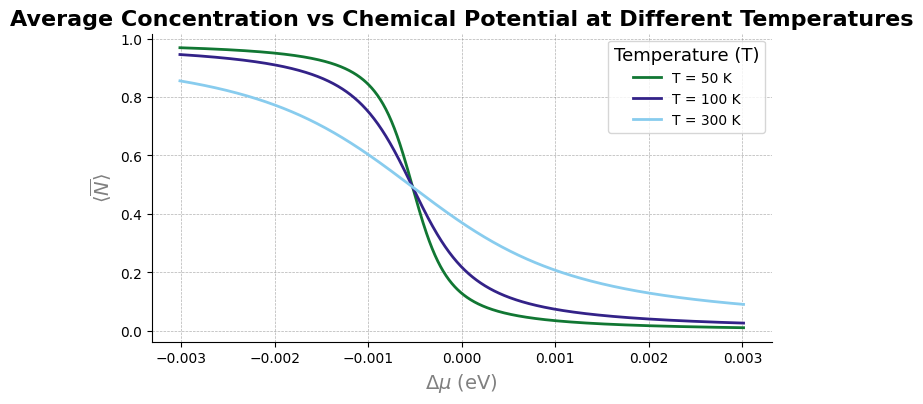

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy

# Assume necessary functions and objects are defined

structure = copy.deepcopy(graphene_mol_r_6_6_pbc)

size = 100000
binary_vector_all = []
Ryd_classical_E = []
concentration = []

# Parameters
num_sites = graphene_mol_r_6_6.num_sites
max_conc = graphene_mol_r_6_6.num_sites

T_all = [50, 100, 300]

concentration = np.random.randint(0, max_conc, size=size)

global_detuning_range = np.linspace(-reg_coef[0] * 10, reg_coef[0] * 10, 1000)

# Generate binary vectors and energy values
for conc in concentration:
    ones = np.random.choice(num_sites, conc, replace=False)
    x = np.zeros(num_sites, dtype='int')
    x[ones] = 1
    binary_vector_all.append(x)

Ryd_classical_E = calculate_Ryd_energy_pbc(
    structure, binary_vector_all, reg_coef, neighbor_count, scaling_factors
)

# Convert lists to numpy arrays
binary_vector_all = np.array(binary_vector_all)
Ryd_classical_E = np.array(Ryd_classical_E)
concentration = np.array(concentration)

# Plotting average concentration across detuning for each temperature
plt.figure(figsize=(8, 4))

# Colorblind-friendly palette
colorblind_friendly_colors = ["#117733", "#332288", "#88CCEE"]

for idx, T in enumerate(T_all):
    av_conc_classical = []
    for glob_det in global_detuning_range:
        # Calculate energy with detuning and get partition function
        energy_new = Ryd_classical_E + concentration * glob_det
        Z, pi = get_partition_function(
            energy_new, [1] * len(Ryd_classical_E), return_pi=True, T=T
        )
        av_conc_classical.append(np.sum(pi * concentration))
    
    av_conc_classical = np.array(av_conc_classical)
    plt.plot(
        global_detuning_range, 
        av_conc_classical / num_sites, 
        label=f'T = {T} K', 
        color=colorblind_friendly_colors[idx], 
        linewidth=2
    )

# Enhancements
plt.xlabel(r'$\Delta \mu$ (eV)', fontsize=14, color='gray')
plt.ylabel(r'$\langle \overline{N} \rangle$', fontsize=14, color='gray')
plt.title(
    'Average Concentration vs Chemical Potential at Different Temperatures', 
    fontsize=16, fontweight='bold'
)
plt.legend(
    title="Temperature (T)", fontsize=10, title_fontsize=13, loc='upper right'
)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show plot
plt.show()

In [296]:
av_conc_classical[-1]

np.float64(0.9568455203579749)

In [316]:
shells = np.unique(np.round(graphene_mol_r_6_6.distance_matrix,4))
np.sum(np.sum(np.round(graphene_mol_r_6_6.distance_matrix,4) == shells[1],axis=1)==2)

np.int64(24)